In [317]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay

# ΜΕΡΟΣ Α
_________________________________________________________________________

Υλοποίηση μιας κλάσης Classifier_ML η οποία θα χρησιμοποιηθεί για την ταξινόμηση τιμών x που ακολουθούν την κατανομή πυκνότητας πιθανότητας: \
$p(x| \theta) = \frac{1}{\pi} \frac{1}{1+{(x - \theta)}^2}$
σε δύο κλάσεις, με τη χρήση των dataset $D_1$, $D_2$.

Η συνάρτηση fit εκτιμά την βέλτιστη τιμή των $\theta_1$, $\theta_2$, οι οποίες αποθηκεύονται και σαν μεταβλητές της κλάσης για μετέπειτα χρήση. \
Η συνάρτηση predict ταξινομεί ένα καινούργιο dataset.

In [318]:
class Classifier_ML:

    theta_estimation_1 = None
    theta_estimation_2 = None

    
    def fit(self, D, thetas, target_class):

        # exception for non valid target class values
        if (target_class not in [1,2]):
            raise Exception ("Non valid target class!")
        
        # Calculate for every sample and every theta, the probability p(x|theta)
        probs_x_theta = (1/np.pi) * (1 / (1 + (D[:, np.newaxis] - thetas)**2))  

        # Compute likelihood p(D|theta) as the product for each theta (along axis 0)
        probs_D_theta = np.prod(probs_x_theta, axis=0)

        # Get the value of theta that maximizes the probability p(D|theta)
        # and store it on the correct variable shown by the target_class
        if (target_class==1):
            self.theta_estimation_1 = thetas[np.argmax(probs_D_theta)]
        else:
            self.theta_estimation_2 = thetas[np.argmax(probs_D_theta)]

        # return the likelihood (to plot it later)
        return probs_D_theta

    
    def predict(self, D, P1, P2):
        
        # Calculate for every sample the probability p(x|theta_1)
        P_x_th1 = (1/np.pi) * (1 / (1 + (D - self.theta_estimation_1)**2))

        # Calculate for every sample the probability p(x|theta_2)
        P_x_th2 = (1/np.pi) * (1 / (1 + (D - self.theta_estimation_2)**2))

        # Return matrix that contains g(x) for every x
        return np.log10(P_x_th1) - np.log10(P_x_th2) + np.log10(P1) - np.log10(P2)


### Ερώτημα 1

Υπολογισμός των εκτιμήσεων $\hat{\theta_1}$, $\hat{\theta_2}$ και plotting των $p(D_1|\theta)$, $p(D_2|\theta)$.

Theta estimation for D1 is:  2.5250501002003958 
 Theta estimation fot D2 is:  -3.2464929859719476


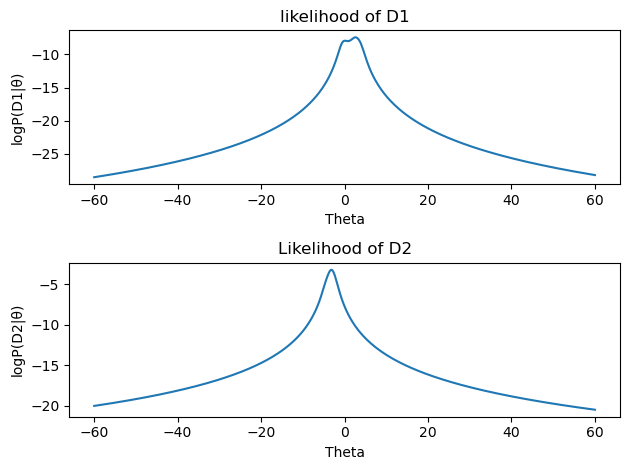

In [319]:
# Create 2 Classifier objects
classifier = Classifier_ML()

# Create the theta values that will be used for the calculations
theta_Num = 500
theta_interval = 120
dtheta = theta_interval / theta_Num
thetas = np.linspace(-theta_interval/2, theta_interval/2, theta_Num)

# Fit models to observations 
D1 = np.array([2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1])

probs_D_theta1 = classifier.fit(D1, thetas, 1)

D2 = np.array([-4.5, -3.4, -3.1, -3.0, -2.3])

probs_D_theta2 = classifier.fit(D2, thetas, 2)

print("Theta estimation for D1 is: ", classifier.theta_estimation_1, "\n", \
    "Theta estimation fot D2 is: ", classifier.theta_estimation_2)

# Plot log( p(D|theta) ) for both classes
fig, ax = plt.subplots(2, 1)
ax[0].plot(thetas, np.log10(probs_D_theta1))
ax[0].set_title("likelihood of D1")
ax[0].set_xlabel("Theta")
ax[0].set_ylabel("logP(D1|θ)")
ax[1].plot(thetas, np.log10(probs_D_theta2))
ax[1].set_xlabel("Theta")
ax[1].set_ylabel("logP(D2|θ)")
ax[1].set_title("Likelihood of D2")
fig.tight_layout()
plt.show()

### Ερώτημα 2

Υπολογισμός των τιμών της συνάρτησης διάκρισης $g(x)$ (*discriminant function*) και plotting συναρτήσει των δειγμάτων του dataset.


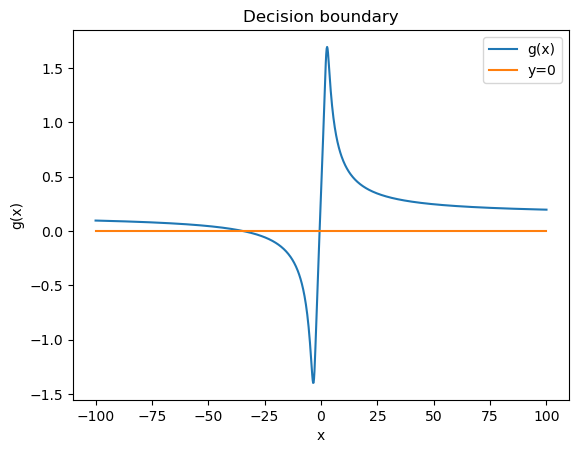

In [320]:
D = np.linspace(-100, 100, 1000)

prediction = classifier.predict(D, 7/12, 5/12)

zero = np.zeros_like(D)
plt.plot(D, prediction)
plt.plot(D, zero)
plt.legend(["g(x)", "y=0"])
plt.xlabel("x")
plt.ylabel("g(x)")
plt.title("Decision boundary")
plt.show()

# ΜΕΡΟΣ Β
____________________________________________________________________________________

Υλοποίηση κλάσης Classifier_Bayes, που θα ταξινομεί πάλι τιμές του x σε δύο κλάσεις, γνωρίζοντας αυτή τη φορά ότι οι τιμές της άγνωστης παραμέτρου θ ακολουθούν τη συνάρτηση πυκνότητας πιθανότητας (prior): $p(\theta) = \frac{1}{10\pi} \frac{1}{1+(\frac{\theta}{10}^2)}$. Χρησιμοποιώντας τη μέθοδο εκτίμησης κατά Bayes, η συνάρτηση fit εκτιμά τις *a posteriori* πιθανότητες $p(\theta|D_1)$, $p(\theta|D_2)$ τις οποίες και αποθηκεύει ως μεταβλητές της κλάσης. Στη συνέχεια η συνάρτηση predict, χρησιμοποιεί τις παραπάνω πιθανότητες και υπολογίζει τις τιμές μιας συνάρτησης διάκρισης με τη βοήθεια της οποίας ταξινομούμε δείγματα καινούριου dataset.

In [321]:
# Function to estimate an integral using the trapezoid rule
# it takes as an input the sampling of a function and the sampling period
def trapezoid_integral (f:np.array, dx:float):
    return np.sum (0.5 * ( f[0:len(f)-1] + f[1:len(f)] ) * dx)


In [322]:
class Classifier_Bayes:
    # a posteriori probabilities p(theta|D1), p(theta|D2)
    P_theta_D1 = None
    P_theta_D2 = None

    def fit(self, D, thetas, dtheta, target_class):

        # exception for non valid target_class values
        if (target_class not in [1,2]):
            raise Exception ("Non valid target class!")
        
        # Calculate for every sample and every theta, the probability p(x|theta)
        probs_x_theta = (1/np.pi) * (1 / (1 + (D[:, np.newaxis] - thetas)**2))  

        # Compute likelihood p(D|theta) as the product for each theta (along axis 0)
        probs_D_theta = np.prod(probs_x_theta, axis=0)  

        # Calculate prior probability p(theta)
        probs_theta = ( 1 / 10*np.pi ) * ( 1 / ( 1 + (thetas/10)**2 ) )

        # Calculate integral p(D|theta)p(theta) dtheta
        integral = trapezoid_integral( probs_D_theta * probs_theta, dtheta )

        # Calculate a posteriori probability p(theta|D)
        P_theta_D = ( probs_D_theta * probs_theta ) / integral

        # store the a posteriori probability in the correct variable
        if (target_class==1):
            self.P_theta_D1 = P_theta_D
        else:
            self.P_theta_D2 = P_theta_D


    def predict(self, D, P1, P2, thetas, dtheta):

        # Calculate for every sample of the new dataset and every theta, the probability p(x|theta)
        probs_x_theta = (1/np.pi) * (1 / (1 + (D[:, np.newaxis] - thetas)**2))  

        # make an empty instance for the probabilities p(x|D1) of every x in the new dataset
        probs_x_D1 = np.empty(len(D))
        for i in range (len(D)):
            # Calculate p(x|D1) as the integral of p(x|theta)*p(theta|D1) for every x in the new dataset
            # p(x|theta) is the i row in the probs_x_theta matrix and p(theta|D1) is stored in the class
            probs_x_D1[i] = trapezoid_integral( probs_x_theta[i] * self.P_theta_D1, dtheta )

        # make an empty instance for the probabilities p(x|D2) of every x in the new dataset
        probs_x_D2 = np.empty(len(D))
        for i in range (len(D)):
            # Calculate p(x|D2) as the integral of p(x|theta)*p(theta|D2) for every x in the new dataset
            # p(x|theta) is the i row in the probs_x_theta matrix and p(theta|D2) is stored in the class
            probs_x_D2[i] = trapezoid_integral( probs_x_theta[i] * self.P_theta_D2, dtheta )
        
        # calculate and return h(x)
        return np.log10(probs_x_D1) - np.log10(probs_x_D2) + np.log10(P1) - np.log10(P2)

        


### Ερώτημα 1

Υπολογισμός των *a posteriori* πιθανοτήτων $p(\theta|D_1)$, $p(\theta|D_2)$ και plotting συναρτήσει της παραμέτρου *θ*.

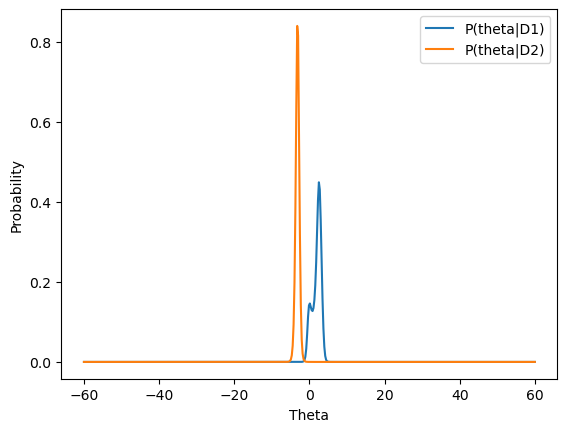

In [323]:
classifier_bayes = Classifier_Bayes()

# Fit models to observations
classifier_bayes.fit(D1, thetas, dtheta, 1)
classifier_bayes.fit(D2, thetas, dtheta, 2)

# Plot the posterior probability p(theta|D1)
plt.plot(thetas, classifier_bayes.P_theta_D1)

# Plot the posterior probability p(theta|D2)
plt.plot(thetas, classifier_bayes.P_theta_D2)


plt.legend(["P(theta|D1)", "P(theta|D2)"])
plt.xlabel("Theta")
plt.ylabel("Probability")
plt.show()


### Ερώτημα 2

Υπολογισμός των τιμών της συνάρτησης διάκρισης $h(x)$ (*discrimant function*) και plotting συναρτήσει των δειγμάτων του dataset.



[1.48102334 0.46254521 0.22887315 1.42208733 0.51486261 1.41936393
 1.31245897]
[-1.03828739 -1.16224848 -1.11494624 -1.08892862 -0.77526127]


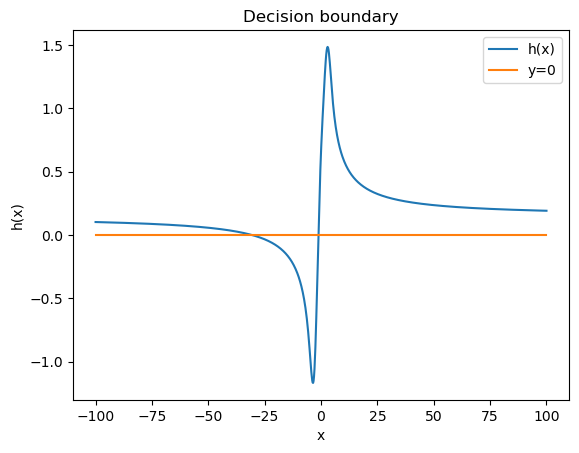

In [324]:
print(classifier_bayes.predict(D1, 7/12, 5/12, thetas, dtheta))

print(classifier_bayes.predict(D2, 7/12, 5/12, thetas, dtheta))

# Prediction for the new dataset
prediction = classifier_bayes.predict(D, 7/12, 5/12, thetas, dtheta)

# Plot prediction for the new dataset
plt.plot(D, prediction)
plt.plot(D, zero)
plt.legend(["h(x)", "y=0"])
plt.xlabel("x")
plt.ylabel("h(x)")
plt.title("Decision boundary")
plt.show()

# ΜΕΡΟΣ Γ 


### Ενότητα 1

0.7866666666666666 DecisionTreeClassifier(max_depth=3, random_state=42)


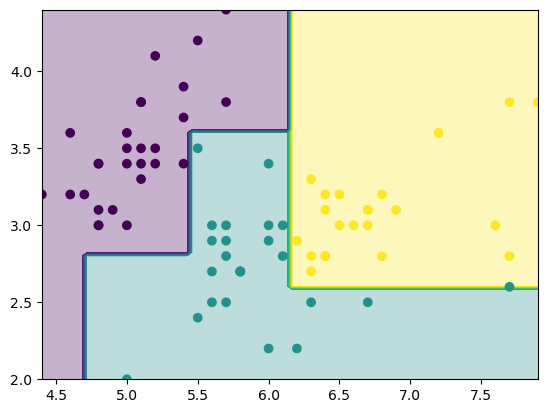

In [341]:
# Load the iris dataset
iris = datasets.load_iris() 
X = iris.data
y = iris.target

# Reduce the dataset to 2 features
X_reduced = X[:, 0:2]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.5, random_state=42)

# Create a Decision Tree Classifier
DTC = DecisionTreeClassifier(random_state=42)


# Function to tune the model using GridSearchCV
def tune_model(model, param_grid):
    grid = GridSearchCV(model, param_grid, cv=3) # Create a GridSearchCV object
    grid.fit(X_train, y_train) # Train the model
    y_pred = grid.predict(X_test) # Make predictions
    accuracy = accuracy_score(y_test, y_pred) # Calculate accuracy
    best_model = grid.best_estimator_ # Get the best model
    return accuracy, best_model

# Tune the model
param_grid = {'max_depth': np.arange(1, 10)}
best_accuracy, best_model = tune_model(DTC, param_grid)
y_pred = best_model.predict(X_test)
print(best_accuracy, best_model)

# Plot the decision boundary
feature_1, feature_2 = np.meshgrid(np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100), np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 100))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
predictions = best_model.predict(grid).reshape(feature_1.shape)
plt.contourf(feature_1, feature_2, predictions, alpha=0.3, cmap='viridis',levels=100)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)





### Ενότητα 2